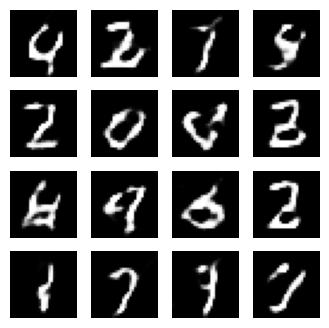

KeyboardInterrupt: 

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Define the generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

# Define the discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Define the training loop
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF
        display.clear_output(wait=True) # Now you can use display.clear_output()
        generate_and_save_images(generator, epoch + 1, seed)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Train the model
train(train_dataset, EPOCHS)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
latent_dim = 2
encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder = Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()

# VAE model
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed

vae = VAE(encoder, decoder)
vae.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
train_images = np.expand_dims(train_images, -1).astype('float32') / 255.0
test_images = np.expand_dims(test_images, -1).astype('float32') / 255.0
vae.fit(train_images, train_images, epochs=100, batch_size=128)

# Generate new images
def plot_latent_space(vae, n=30, figsize=15):
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # Linearly spaced coordinates on the unit square were transformed
    # through the inverse CDF (ppf) of the Gaussian to produce values
    # of the latent variables z, since the prior of the latent space
    # is Gaussian
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(vae)


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 14, 14, 32)     │            320 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 3136)           │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 16)             │         50,192 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │             34 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │             34 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 92s 182ms/step - loss: 0.0964
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 133s 164ms/step - loss: 0.0673
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 75s 159ms/step - loss: 0.0673
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - loss: 0.0674
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 86s 168ms/step - loss: 0.0674
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 165ms/step - loss: 0.0674
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 163ms/step - loss: 0.0672
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 163ms/step - loss: 0.0675
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 75s 160ms/step - loss: 0.0673
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 76s 163ms/step - loss: 0.0675
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 75s 160ms/step - loss: 0.0673
Epoch 12/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 162ms/step - loss: 0.0673
Epoch 13/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 162ms/step - loss: 0.0673
Epoch 14/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 162ms/step - loss: 0.0673
